In [1]:
import pandas as pd
import numpy as np 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import roc_curve, plot_confusion_matrix, classification_report,confusion_matrix, f1_score, accuracy_score, roc_auc_score
from imblearn.ensemble import BalancedRandomForestClassifier


In [5]:
df1 = pd.read_csv("../all_data_1.csv")
df2 = pd.read_csv("../all_data_2.csv")
df = pd.concat([df1,df2])
disordered = df.loc[df["label"]==1.0]
label_dis = disordered["label"]
disordered = disordered.drop(columns=["label", "sequence"])
ordered = df.loc[df["label"]==0.0]
label_ord = ordered["label"]
ordered = ordered.drop(columns=["label", "sequence"])

# 16316 disordered => 0.236 
# 240481 total ordered 
# 7704 => 3852 
#split ordered
xo_train, xo_test, yo_train, yo_test = train_test_split(disordered, label_dis, test_size=0.236)
#split disordered
xd_train, xd_test, yd_train, yd_test = train_test_split(ordered, label_ord, test_size=0.016)
#concatenate the two
X_train = pd.concat([xo_train, xd_train]).to_numpy().astype('float32')
y_train = pd.concat([yo_train, yd_train]).to_numpy().astype('float32')

X_test = pd.concat([xo_test, xd_test]).to_numpy().astype('float32')
y_test = pd.concat([yo_test, yd_test]).to_numpy().astype('float32')

print('Number of observations in the training data:', len(X_train))
print('Number of observations in the test data:',len(y_train))
"""df = df.drop(columns=["sequence"])
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0) 
print(X_train.shape)
print(X_test.shape)"""

Number of observations in the training data: 249098
Number of observations in the test data: 249098


'df = df.drop(columns=["sequence"])\nX = df.iloc[:,:-1]\ny = df.iloc[:,-1]\nX_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=0) \nprint(X_train.shape)\nprint(X_test.shape)'

In [6]:
# balanced random forest 
brfc = BalancedRandomForestClassifier(n_estimators=100).fit(X_train,y_train)
print('Training set score: ' + str(brfc.score(X_train,y_train)))
print('Test set score: ' + str(brfc.score(X_test,y_test)))

#print("F1 Score for Balanced Random Forest Classifier is ", f1_score(test_labels, pred))
#print("Accuracy  Score for Balanced Random Forest Classifier is ", accuracy_score(test_labels,pred))
#print("roc_auc  Score for Balanced Random Forest Classifier is ", roc_auc_score(test_labels,pred)) => want to use class probabilities for this

Training set score: 0.8990678367550121
Test set score: 0.8227042473048448


In [7]:
print("roc_auc Score for Balanced Random Forest Classifier is ", roc_auc_score(y_test,brfc.predict_proba(X_test)[:,1]))

roc_auc Score for Balanced Random Forest Classifier is  0.9036577763369505


In [8]:
pred = brfc.predict(X_test)
print(confusion_matrix(y_test,pred))
print(classification_report(y_test,pred))

[[3392  456]
 [ 909 2942]]
              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83      3848
         1.0       0.87      0.76      0.81      3851

    accuracy                           0.82      7699
   macro avg       0.83      0.82      0.82      7699
weighted avg       0.83      0.82      0.82      7699



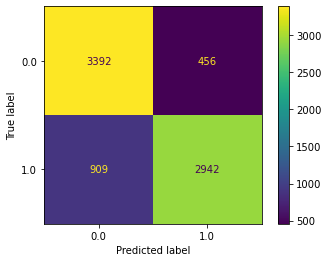

In [9]:
plot_confusion_matrix(brfc, X_test, y_test)

In [10]:
from sklearn.pipeline import Pipeline # For setting up pipeline
# Various pre-processing steps
from sklearn.preprocessing import Normalizer, StandardScaler, MinMaxScaler, PowerTransformer, MaxAbsScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV # For optimization

pipe = Pipeline([('classifier', BalancedRandomForestClassifier())])
parameters = {'classifier__criterion':["gini", "entropy"], 'classifier__min_samples_split':[2,4,6,8], 'classifier__max_depth':[25, 30, 50, 75, 100]}
grid = GridSearchCV(pipe, parameters, scoring="roc_auc", cv=2).fit(X_train, y_train)
print('Training set score: ' + str(grid.score(X_train, y_train)))
print('Test set score: ' + str(grid.score(X_test, y_test)))

Training set score: 0.9862276321950437
Test set score: 0.9034123423405428


In [11]:
# Access the best set of parameters
best_params = grid.best_params_
print(best_params)
# Stores the optimum model in best_pipe
best_pipe = grid.best_estimator_
print(best_pipe)

{'classifier__criterion': 'entropy', 'classifier__max_depth': 50, 'classifier__min_samples_split': 2}
Pipeline(steps=[('classifier',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_depth=50))])


In [12]:
from pandas import DataFrame
result_df = DataFrame.from_dict(grid.cv_results_, orient='columns')
print(result_df.columns)

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_classifier__criterion', 'param_classifier__max_depth',
       'param_classifier__min_samples_split', 'params', 'split0_test_score',
       'split1_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')


In [13]:
result_df.to_csv("pipe_roc_auc_balanced_test_results.csv")

              precision    recall  f1-score   support

         0.0       0.79      0.88      0.83      3848
         1.0       0.87      0.76      0.81      3851

    accuracy                           0.82      7699
   macro avg       0.83      0.82      0.82      7699
weighted avg       0.83      0.82      0.82      7699



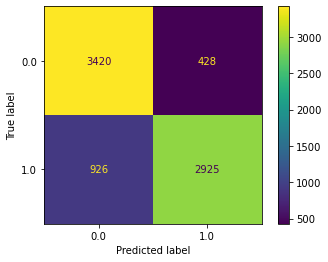

In [14]:
plot_confusion_matrix(best_pipe, X_test, y_test)
print(classification_report(y_test,pred))

best params: {'classifier__criterion': 'entropy', 'classifier__max_depth': 50, 'classifier__min_samples_split': 2}
Pipeline(steps=[('classifier',
                 BalancedRandomForestClassifier(criterion='entropy',
                                                max_depth=50))])

In [16]:
# find feature importance
list(zip(xo_train.columns, brfc.feature_importances_))

[('seq_len', 0.05116274506537775),
 ('molecular_weight', 0.057769612835829466),
 ('hydrophobicity', 0.045338647935230354),
 ('instability_index', 0.04788413432641794),
 ('aromaticity', 0.031565189733197434),
 ('A %', 0.061884520817477154),
 ('C %', 0.03234058896819296),
 ('D %', 0.03157212763291609),
 ('E %', 0.03415870690670007),
 ('F %', 0.03083697119080141),
 ('G %', 0.05340886347978918),
 ('H %', 0.03266469575658316),
 ('I %', 0.04485639853104817),
 ('K %', 0.04550135973950739),
 ('L %', 0.03034818827988141),
 ('M %', 0.031778459528511285),
 ('N %', 0.062313404559151),
 ('P %', 0.038804799847345785),
 ('Q %', 0.031605128269039745),
 ('R %', 0.03385794895051455),
 ('S %', 0.03551994581973948),
 ('T %', 0.03431703284760226),
 ('V %', 0.03828286096203847),
 ('W %', 0.03133389427413242),
 ('Y %', 0.03089377374297507)]

In [17]:
print("roc_auc Score for Balanced Random Forest Classifier is ", roc_auc_score(y_test,best_pipe.predict_proba(X_test)[:,1]))

roc_auc Score for Balanced Random Forest Classifier is  0.9034123423405428


In [19]:
predict_prob = best_pipe.predict_proba(X_test)

# roc curve for models
fpr1, tpr1, thresh1 = roc_curve(y_test, predict_prob[:,1], pos_label=1)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test))]
p_fpr, p_tpr, _ = roc_curve(y_test, random_probs, pos_label=1)

In [20]:
print("roc_auc Score for Balanced Random Forest Classifier is ", roc_auc_score(y_test,predict_prob[:,1]))

roc_auc Score for Balanced Random Forest Classifier is  0.9034123423405428


In [21]:
print(y_test)
print(predict_prob)
print(predict_prob[:,1])

[1. 1. 1. ... 0. 0. 0.]
[[0.01       0.99      ]
 [0.         1.        ]
 [0.39       0.61      ]
 ...
 [0.98       0.02      ]
 [0.67       0.33      ]
 [0.70178571 0.29821429]]
[0.99       1.         0.61       ... 0.02       0.33       0.29821429]


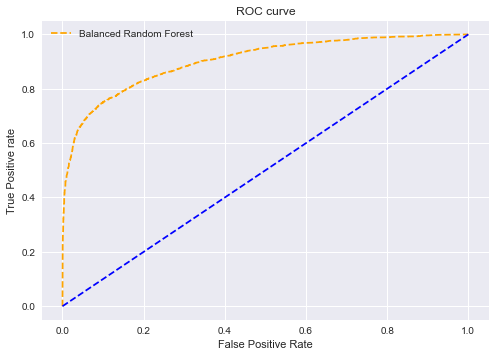

In [22]:
# matplotlib
plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr1, tpr1, linestyle='--',color='orange', label='Balanced Random Forest')
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=600)
plt.show()